In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [2]:
%matplotlib inline
#import utils_modified; reload(utils_modified)
#from utils_modified import *
from __future__ import division, print_function

In [3]:
import numpy as np
import random
import sys

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, LSTM, Flatten, Dropout, Lambda
from keras.models import Model, Sequential
#from keras.layers import merge # deprecated in Keras 2
from keras.layers.merge import Add, add
#from keras.engine.topology import Merge # deprecated in Keras 2
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import *
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical

Using Theano backend.


### Usefull Keras guides to get started
* https://keras.io/getting-started/sequential-model-guide/
* https://keras.io/getting-started/functional-api-guide/

In [5]:
# https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read()#.lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

corpus length: 600901
total chars: 85
nb sequences: 200287


In [6]:
lag = 6

In [7]:
idx = [char_indices[c] for c in text]

Xs = []
for l in range(lag):
    cdat = [idx[i+l] for i in xrange(0, len(idx)-1-lag, lag)]
    X = np.stack(cdat[:-2])
    Xs.append(X)

cdat = [idx[i+(l+1)] for i in xrange(0, len(idx)-1-lag, lag)]
Y = np.stack(cdat[:-2])

In [8]:
len(Xs), Xs[0].shape

(6, (100147,))

### Utility to inspect model predictive power

In [9]:
def show_top_next(mdl, inp):
    pad_inp = (' '*lag)+inp
    idxs = [char_indices[c] for c in pad_inp][-lag:]
    ps = mdl.predict([np.array([i]) for i in idxs])
    probas = ps[0]/np.sum(ps)
    for i in range(5):
        index = np.random.choice(range(len(chars)), size=None, replace=True, p=probas)
        print(inp+chars[index])
    print('')
    
teststrs = ['this i','hersel','himsel','moral','moralit','knowledg','logica','hypothesi']

### Unrolled RNN built with a loop

In [10]:
hdim = 250

In [11]:
def Maker1():
    inputs = [Input(shape=(1,), dtype='int64') for i in range(lag)]

    E = Embedding(output_dim=hdim, input_dim=len(chars), input_length=1)

    Di2h = Dense(hdim, activation='relu')
    Dh2h = Dense(hdim, activation='relu', kernel_initializer='identity')

    #hidden = ... CONSTANT ZERO TENSOR IN KERAS ?

    e = Di2h(Flatten()(E(inputs[0])))
    hidden = e
    for i in range(1,lag):
        e = Di2h(Flatten()(E(inputs[i])))
        #hidden = merge([e, Dh2h(hidden)], mode='sum')
        hidden = add([e, Dh2h(hidden)])
    predictions = Dense(len(chars), activation='softmax')(hidden)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model1 = Maker1()

In [37]:
model1.optimizer.lr = 1e-3
hist1 = model1.fit(Xs, to_categorical(Y,len(chars)), batch_size=100, epochs=25)

Epoch 1/25
100147/100147 [==============================] - 6s - loss: 1.6089 - acc: 0.5183     
Epoch 2/25
100147/100147 [==============================] - 6s - loss: 1.6038 - acc: 0.5200     
Epoch 3/25
100147/100147 [==============================] - 6s - loss: 1.5975 - acc: 0.5203     
Epoch 4/25
100147/100147 [==============================] - 6s - loss: 1.5923 - acc: 0.5221     
Epoch 5/25
100147/100147 [==============================] - 6s - loss: 1.5870 - acc: 0.5221     
Epoch 6/25
100147/100147 [==============================] - 6s - loss: 1.5806 - acc: 0.5242     
Epoch 7/25
100147/100147 [==============================] - 6s - loss: 1.5755 - acc: 0.5273     
Epoch 8/25
100147/100147 [==============================] - 6s - loss: 1.5709 - acc: 0.5267     
Epoch 9/25
100147/100147 [==============================] - 6s - loss: 1.5659 - acc: 0.5276     
Epoch 10/25
100147/100147 [==============================] - 6s - loss: 1.5607 - acc: 0.5300     
Epoch 11/25
100147/100147 [==

In [38]:
for teststr in teststrs:
    show_top_next(model1, teststr)

this is
this is
this im
this it
this is

hersele
hersel 
hersels
hersel;
herseld

himself
himself
himselt
himself
himself

morali
moral,
morali
morali
morali

morality
morality
morality
morality
morality

knowledge
knowledge
knowledge
knowledge
knowledge

logical
logical
logical
logical
logical

hypothesis
hypothesik
hypothesis
hypothesis
hypothesis



### Unrolled RNN with BatchNormalization

In [13]:
def Maker2():
    inputs = [Input(shape=(1,), dtype='int64') for i in range(lag)]

    E = Embedding(output_dim=hdim, input_dim=len(chars), input_length=1)

    Di2h = Dense(hdim, activation='relu')
    Dh2h = Dense(hdim, activation='relu', kernel_initializer='identity')

    #hidden = ... CONSTANT ZERO TENSOR IN KERAS ?
    
    e = Di2h(Flatten()(E(inputs[0])))
    hidden = BatchNormalization()(e)
    for i in range(1,lag):
        e = Di2h(Flatten()(E(inputs[i])))
        #hidden = merge([BatchNormalization()(e), Dh2h(hidden)], mode='sum') # deprecated
        hidden = add([BatchNormalization()(e), Dh2h(hidden)])
    predictions = Dense(len(chars), activation='softmax')(hidden)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model2 = Maker2()

In [41]:
model2.optimizer.lr = 1e-3
hist2 = model2.fit(Xs, to_categorical(Y,len(chars)), batch_size=100, epochs=25)

Epoch 1/25
100147/100147 [==============================] - 16s - loss: 2.3975 - acc: 0.3237    
Epoch 2/25
100147/100147 [==============================] - 16s - loss: 2.1611 - acc: 0.3835    
Epoch 3/25
100147/100147 [==============================] - 16s - loss: 2.0618 - acc: 0.4091    
Epoch 4/25
100147/100147 [==============================] - 16s - loss: 1.9879 - acc: 0.4287    
Epoch 5/25
100147/100147 [==============================] - 16s - loss: 1.9325 - acc: 0.4439    
Epoch 6/25
100147/100147 [==============================] - 16s - loss: 1.8864 - acc: 0.4551    
Epoch 7/25
100147/100147 [==============================] - 16s - loss: 1.8480 - acc: 0.4637    
Epoch 8/25
100147/100147 [==============================] - 16s - loss: 1.8164 - acc: 0.4707    
Epoch 9/25
100147/100147 [==============================] - 16s - loss: 1.7860 - acc: 0.4792    
Epoch 10/25
100147/100147 [==============================] - 16s - loss: 1.7603 - acc: 0.4844    
Epoch 11/25
100147/100147 [==

In [57]:
for teststr in teststrs:
    show_top_next(model2, teststr)

this ia
this in
this is
this in
this is

hersels
hersel 
hersels
hersels
hersel 

himself
himself
himself
himself
himself

morali
moral.
morali
morali
moral 

morality
morality
morality
morality
morality

knowledge
knowledge
knowledge
knowledge
knowledge

logical
logical
logical
logical
logical

hypothesil
hypothesic
hypothesil
hypothesis
hypothesis



### Compare training convergence of the 2 models

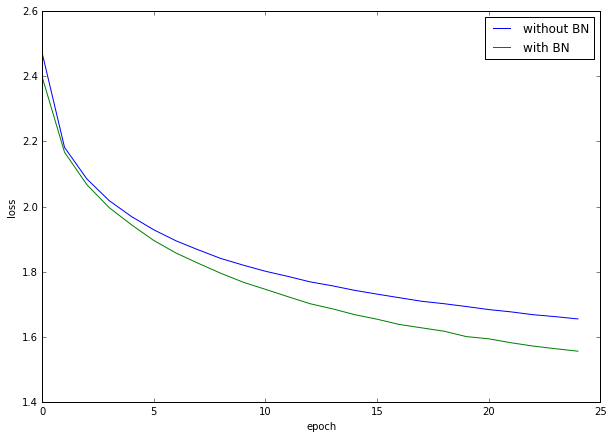

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['without BN','with BN'], loc='upper right')
plt.show()